# Simulated examples for bias detection

In [1]:
import random
from bias_tree import BiasDetectionTree
from data_preparation.movielens_100k import MovieLens100KData
from data_preparation.book_crossing import BookCrossingData

### Prepare MovieLens dataset 

In [2]:
# data = MovieLens100KData(data_path='data/ml-100k')
data = BookCrossingData(data_path='data/book-crossing', sample=100)

ratings_with_metadata = data.get_ratings_with_metadata()
ratings_with_metadata.head()


C:\Users\Asia\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,User-ID,ISBN,Book-Rating,country,Location,Age,country_x,country_y,Book-Title,Book-Author,...,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user activity,item popularity,user activity_bucketized,item popularity_bucketized,Age_bucketized,Year-Of-Publication_bucketized
59218,172742,0671726889,10,Country:usa,"astoria, oregon, usa",44.0,Country:usa,139711,CUCKOO'S EGG,Clifford Stoll,...,Pocket,http://images.amazon.com/images/P/0671726889.0...,http://images.amazon.com/images/P/0671726889.0...,http://images.amazon.com/images/P/0671726889.0...,215,21,"(151.0, 5802.0]","(14.0, 23.0]","(43.0, 239.0]","(-0.001, 1992.0]"
83269,160548,0060973897,9,"Country:,","orlando, ,",22.0,"Country:,",2889,Lakota Woman,Dog Mary Crow,...,Perennial,http://images.amazon.com/images/P/0060973897.0...,http://images.amazon.com/images/P/0060973897.0...,http://images.amazon.com/images/P/0060973897.0...,11,14,"(9.999, 19.0]","(9.999, 14.0]","(-1.001, 26.0]","(-0.001, 1992.0]"
60414,197410,0151001006,9,Country:sweden,"stockholm, stockholm, sweden",31.0,Country:sweden,1406,Snow Falling on Cedars,David Guterson,...,Harcourt,http://images.amazon.com/images/P/0151001006.0...,http://images.amazon.com/images/P/0151001006.0...,http://images.amazon.com/images/P/0151001006.0...,31,14,"(19.0, 39.0]","(9.999, 14.0]","(26.0, 33.0]","(1992.0, 1997.0]"
80515,273976,0060987049,7,Country:usa,"saratoga, california, usa",20.0,Country:usa,139711,Microserfs,Douglas Coupland,...,Regan Books,http://images.amazon.com/images/P/0060987049.0...,http://images.amazon.com/images/P/0060987049.0...,http://images.amazon.com/images/P/0060987049.0...,32,22,"(19.0, 39.0]","(14.0, 23.0]","(-1.001, 26.0]","(1992.0, 1997.0]"
43009,106294,014023313X,9,Country:usa,"tarrytown, new york, usa",-1.0,Country:usa,139711,The Stone Diaries,Carol Shields,...,Penguin Books,http://images.amazon.com/images/P/014023313X.0...,http://images.amazon.com/images/P/014023313X.0...,http://images.amazon.com/images/P/014023313X.0...,17,59,"(9.999, 19.0]","(40.0, 81.0]","(-1.001, 26.0]","(1992.0, 1997.0]"


In [ ]:
ratings_with_metadata = data._get_ratings()
ratings_with_metadata[data.ITEM_ID_COL] = ratings_with_metadata[data.ITEM_ID_COL].astype(str)

In [ ]:
ratings_with_metadata.pivot_table(index=data.USER_ID_COL, columns=data.ITEM_ID_COL,
                                       values=data.RATING_COL)

In [3]:
MIN_CHILD_NODE_SIZE = 10000

### Analyze bias examples

Higher metric for females and crime movies

root=[]: 2.966
├── Crime=[0]: 3.002
│   ├── user activity_bucketized=['(143.0, 215.0]', '(19.999, 74.0]', '(215.0, 305.0]']: 3.004
│   └── user activity_bucketized=['(305.0, 737.0]', '(74.0, 143.0]']: 2.999
│       ├── LOF_bucketized=['(-1.28, -0.982]', '(-1.537, -1.399]']: 2.991
│       └── LOF_bucketized=['(-1.399, -1.28]', '(-1.726, -1.537]', '(-2.5469999999999997, -1.726]']: 3.003
└── Crime=[1]: 2.567
    ├── gender=['F']: 0.994
    └── gender=['M']: 3.016
        ├── LOF_bucketized=['(-1.28, -0.982]', '(-1.726, -1.537]', '(-1.537, -1.399]']: 3.015
        └── LOF_bucketized=['(-1.399, -1.28]', '(-2.5469999999999997, -1.726]']: 3.019



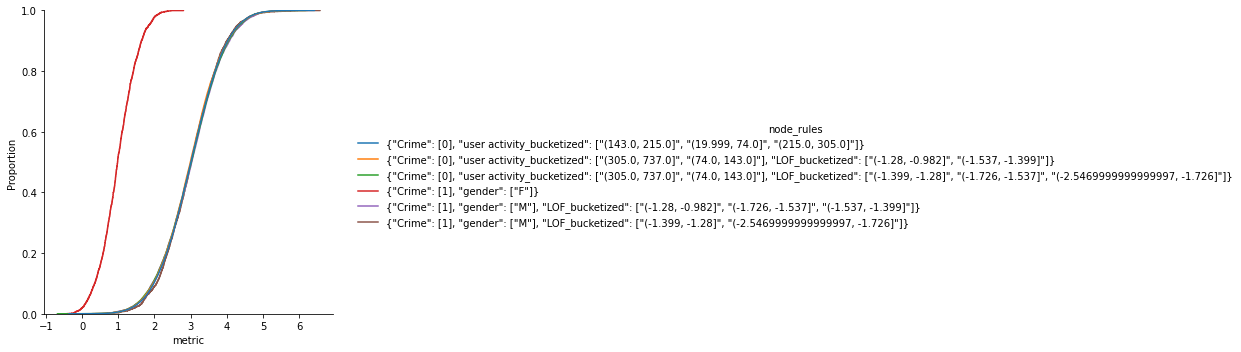

In [4]:
metric_name = 'metric'
metric_distribution_bias_female_crime = lambda x: random.normalvariate(1, .5) if (x['Crime']>0 and x['gender']=='F') \
                                                                                else random.normalvariate(3, 0.8)

ratings_with_metadata[metric_name] = ratings_with_metadata.apply(metric_distribution_bias_female_crime,  1)
bias_detection_tree = BiasDetectionTree(min_child_node_size=1000, alpha=0.01, metric_col=metric_name)
node_metric = bias_detection_tree.analyze_bias(attributes=data.attributes_dict, metric_with_metadata=ratings_with_metadata)

Lower metric for young users

root=[]: 0.823
├── Age_bucketized=['(-1.001, 20.0]', '(20.0, 36.0]']: 0.5
└── Age_bucketized=['(36.0, 244.0]']: 1.501



,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""Age_bucketized"": [""(-1.001, 20.0]"", ""(20.0, 36.0]""]}",250105.0,0.500057,0.100141,0.062009,0.432553,0.499984,0.567743,0.933722
"{""Age_bucketized"": [""(36.0, 244.0]""]}",118903.0,1.500756,0.199961,0.642433,1.365817,1.500750,1.635048,2.319318


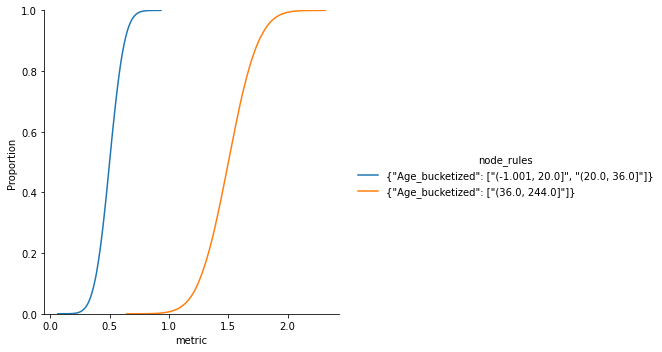

In [7]:
metric_name = 'metric'
metric_distribution_bias_young = lambda x: random.normalvariate(0.5, .1) if x['age']<=36 \
                                                                                else random.normalvariate(1.5, .2)
ratings_with_metadata[metric_name] = ratings_with_metadata.apply(metric_distribution_bias_young,  1)
bias_detection_tree = BiasDetectionTree(min_child_node_size=MIN_CHILD_NODE_SIZE, alpha=0.001, metric_col=metric_name)
node_metric = bias_detection_tree.analyze_bias(attributes=data.attributes_dict, metric_with_metadata=ratings_with_metadata)
node_metric

No bias

root=[]: 1.499



,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
{},8507.0,1.499372,0.099308,1.137893,1.431756,1.498879,1.565816,1.854067


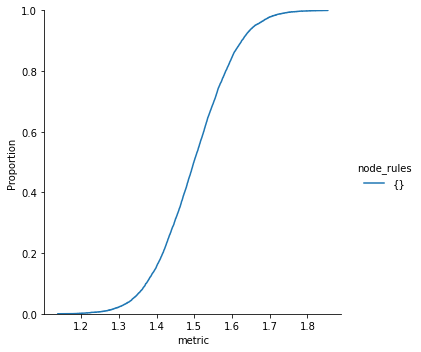

In [5]:
metric_name = 'metric'
metric_normal = lambda x: random.normalvariate(1.5, .1) 

ratings_with_metadata[metric_name] = ratings_with_metadata.apply(metric_normal,  1)
bias_detection_tree = BiasDetectionTree(min_child_node_size=1000, alpha=0.01, metric_col=metric_name)
node_metric = bias_detection_tree.analyze_bias(attributes=data.attributes_dict, metric_with_metadata=ratings_with_metadata)
node_metric